In [34]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.ndimage as spi
import os
import pandas as pd
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch, ZScaleInterval
from matplotlib.colors import CenteredNorm, TwoSlopeNorm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astropy.nddata import Cutout2D
from skimage import restoration
import astropy as astro
from matplotlib.colors import LogNorm
from astropy.io import fits
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pylab as pylab
from photutils.psf import EPSFBuilder, EPSFStars, extract_stars
from astropy.nddata import NDData
from astropy.table import Table
import astropy.units as u
from scipy.signal.windows import tukey

plt.style.use("science")
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25,
        'xtick.major.size': 8,
        'xtick.minor.size': 4,
        'xtick.major.width': 1,
        'xtick.minor.width': 1,
        'ytick.major.size': 8,
        'ytick.minor.size': 4,
        'ytick.major.width': 1,
        'ytick.minor.width': 1,
        'font.size': 15 # for annotate
         }
pylab.rcParams.update(params)


In [2]:
# datapath = os.getenv("project") + "/data/CosmicHorseshoe/hst_11602_02_wfc3_uvis_f814w_sci.fits"
datapath = "/media/alexandre/Seagate/Data/Horseshoe/hst_11602_02_wfc3_uvis_f814w_sci.fits"

data = fits.open(datapath)

In [3]:
pixel_scale = data["PRIMARY"].header["D001SCAL"]
pixel_scale # arcsec

0.0396200008690344

In [4]:
exptime = data["PRIMARY"].header["EXPTIME"]
print(f"exposure time: {exptime} s")
image = data["SCI"].data * exptime # data is now a count
# weights = data["WHT"].data

exposure time: 5592.0 s


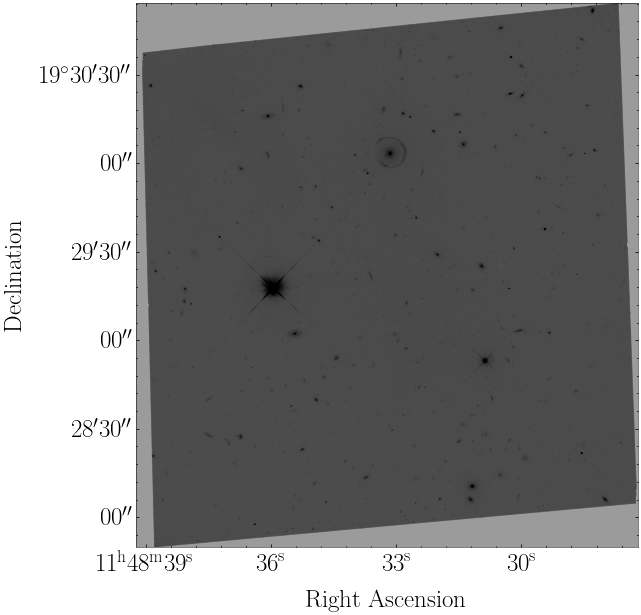

In [5]:
wcs = WCS(data["SCI"].header)
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(image, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch(), vmax=1000))
# plt.colorbar()
ax = plt.gca()
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination');

In [56]:
# Right ascension	11h 48m 33.1s
# Declination	19° 30′ 03″
centroid = SkyCoord(177.13808, 19.50089, unit="deg")
centroid = centroid.to_pixel(wcs)
centroid # in pixel space

size = 350* u.pixel
cutout = Cutout2D(image, centroid, size, wcs=wcs)
cutout_image = cutout.data
wcs_cutout = cutout.wcs
# cutout_image[cutout_image < 0] = 0

In [57]:
daofind = DAOStarFinder(fwhm=3.0, threshold=200)
sources = daofind(cutout_image)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
center = 4

object_positions = sources[[3, 1, 2]]["xcentroid", "ycentroid"].to_pandas().to_numpy() # G, 01, 02
ox, oy = object_positions[:, 0], object_positions[:, 1]

sources[[3, 1, 2]]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
4,168.68183739073956,176.25232334460304,0.5054275508829631,0.18391104760858576,0.662927244884847,25,0.0,6209.94970703125,6.282358047507986,-1.9953067107777445
2,163.04956087623586,85.92819486054093,0.5320887289584947,0.0660976258673923,0.03817337253895813,25,0.0,866.0254516601562,2.7737428695999147,-1.1076654970254516
3,136.10978496262558,158.2186029932781,0.5618818525842484,-0.08005564117983148,0.04655510690408533,25,0.0,1782.9403076171875,5.989953025687427,-1.9435585414637901


/home/alexandre/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/alexandre/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/alexandre/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/alexandre/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/alexandre/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


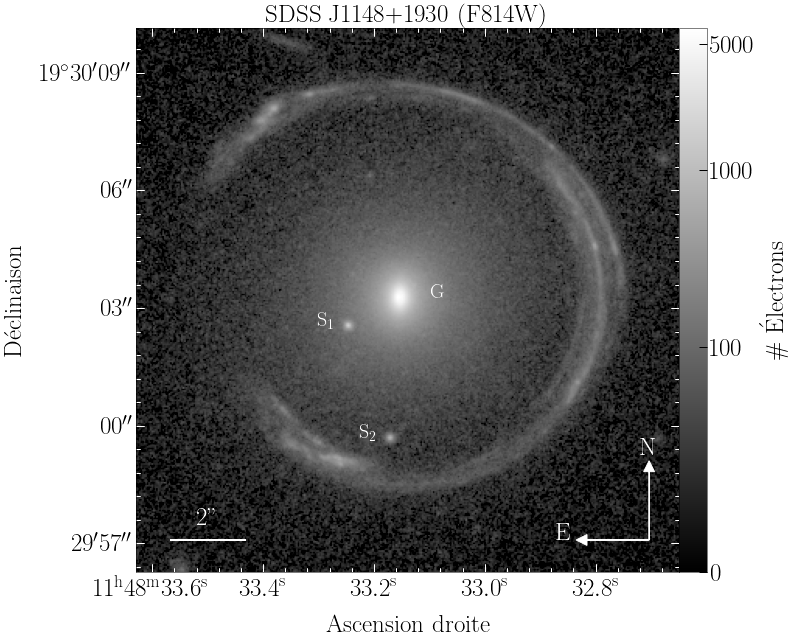

In [77]:
color="w"
fig = plt.figure(figsize=(12, 10))
plt.subplot(projection=wcs_cutout)
# plt.imshow(mask * (cutout_image - bkg) + noise, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch()))
# plt.imshow((cutout_image - bkg)/noise_std, cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=0))
im = plt.imshow(cutout_image - 116.77832, cmap="gray", norm=ImageNormalize(vmin=0, stretch=LogStretch(a=1e3)))


ax = plt.gca()
# cbar = fig.colorbar(im, ax=ax)
cbar = fig.colorbar(im, ax=ax, ticks=[5e3, 1e3, 1e2, 0], label="\# Électrons", pad=0)
# cbar.ax.set_yticklabels([r'$10^4$', r"$10^3$", r"$10^2$", r"$0$"])  # vertically oriented colorbar


ax.set_xlabel('Ascension droite')
ax.set_ylabel('Déclinaison')

# for i in range(len(sources)):
#     ax.annotate(f"{i}",  [ox[i]+10, oy[i]], color="r", fontsize=20)
ax.annotate("G",  [ox[0]+20, oy[0]], color=color, fontsize=20)
ax.annotate(r"S$_2$",  [ox[1]-20, oy[1]], color=color, fontsize=20)
ax.annotate(r"S$_1$",  [ox[2]-20, oy[2]], color=color, fontsize=20)
# ax.annotate("O3",  [ox[3]+10, oy[3]], color="r", fontsize=20)



N, M = cutout_image.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs_cutout.pixel_to_world(x.ravel(), y.ravel())
x = lens_sky.ra.to(u.arcsec) -  lens_sky.ra.min()
y = lens_sky.dec.to(u.arcsec) - lens_sky.dec.min()
FOV = x.max().value
width = x.max().value
deltaPix = (x[1] - x[0]).value
x_center = (x[M//2]).to(u.arcsec).value
y_center = (y[M*N//2]).to(u.arcsec).value

#coordinate array
arrow_size = 0.02
font_size = 25
width = cutout_image.shape[0]
d0 = 20
p0 = 40
pt = 50

xx_, yy_ = (width - d0), d0
xx_ra, yy_ra = xx_ + p0, yy_
xx_dec, yy_dec = xx_, yy_ + 1.1*p0
xx_ra_t, yy_ra_t = xx_ - 1.1*pt, yy_
xx_dec_t, yy_dec_t = xx_, yy_ + 1.1*pt

ax.arrow(xx_ , yy_, -(xx_ra - xx_), -(yy_ra - yy_),
         head_width=arrow_size * width, head_length=arrow_size * width, fc=color, ec=color, linewidth=1)
ax.text(xx_ra_t, yy_ra_t, "E", color=color, fontsize=font_size, ha='center')
ax.arrow(xx_, yy_, (xx_dec - xx_), (yy_dec - yy_),
         head_width=arrow_size * width, head_length=arrow_size * width, fc=color, ec=color, linewidth=1)
ax.text(xx_dec_t, yy_dec_t, "N", color=color, fontsize=font_size, ha='center')

#scale bar
p0 = 70
dist = 2 / deltaPix
ax.plot([p0, p0 + dist], [20, 20], linewidth=2, color=color)
ax.text(p0 + dist / 2., 30, "2''", fontsize=font_size, color=color, ha='center')

ax.tick_params(axis='both', which="both", colors=color, labelcolor="k")    #setting up X-axis tick color to red


ax.set_title("SDSS J1148+1930 (F814W)");
plt.savefig("../figures/sdssj1148.png", bbox_inches="tight")

In [78]:
from astropy.constants import G, c, M_sun
from astropy.cosmology import Planck18
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM 

# cosmo = FlatLambdaCDM(H0=70, Om0=0.3) 
cosmo = Planck18

theta_E = (5.6 * u.arcsec).to(u.rad).value # best fit from Schuldt et al 2019
z_ell = 0.444
z_s = 2.381

D = cosmo.angular_diameter_distance(z_ell) * cosmo.angular_diameter_distance(z_s) / cosmo.angular_diameter_distance_z1z2(z_ell, z_s)

M = (theta_E**2 / 4 / G * c**2 * D / M_sun).decompose()

In [79]:
M

<Quantity 6.69956049e+12>

In [97]:
z_ell = 0.2
z_s = 0.5
D = cosmo.angular_diameter_distance(z_ell) * cosmo.angular_diameter_distance(z_s) / cosmo.angular_diameter_distance_z1z2(z_ell, z_s)
D.to(u.Gpc)

<Quantity 1.24070275 Gpc>

In [116]:
z_ell = 0.5
z_s = 1
D = cosmo.angular_diameter_distance(z_ell) * cosmo.angular_diameter_distance(z_s) / cosmo.angular_diameter_distance_z1z2(z_ell, z_s)
D.to(u.Gpc)

<Quantity 3.04040762 Gpc>

In [106]:
M = 1e11 * M_sun
z_ell = 0.444
z_s = 2.381
# D = cosmo.angular_diameter_distance(z_ell) * cosmo.angular_diameter_distance(z_s) / cosmo.angular_diameter_distance_z1z2(z_ell, z_s)
D = 3 * u.Gpc
theta_E = np.sqrt(4 * G * M / c**2 / D * u.rad**2).to(u.arcsec)
2 * theta_E

<Quantity 1.04203988 arcsec>

In [98]:
np.sqrt(4 * G / c**2 * M_sun / u.Gpc *  u.rad**2).to(u.arcsec)

<Quantity 2.85374373e-06 arcsec>